# Downloading Dataset from Kaggle

When you will run this code, it will ask you to upload the API key file. You will need the kaggle api key to run this code. You can get it from kaggle. The file will be in json format. You can use this link to get the API key to run this code: https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/ or you can use the file I uploaded in the appendix material named Kaggle API key file or if you don't want to do that. You can download the dataset directly and update the root_dir variable with the path of your dataset. To begin, you will have to remove # from the beginning of the code to run it.

In [ ]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en
# ! chmod 600 ~/.kaggle/kaggle.json


 97% 962M/987M [00:10<00:00, 101MB/s]
100% 987M/987M [00:10<00:00, 98.5MB/s]


In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/speech/dataset/speech-emotion-recognition-en.zip" -d "/content/drive/MyDrive/Colab Notebooks/speech/dataset"

In [ ]:
# !cp -r "/content/drive/MyDrive/Colab Notebooks/speech/dataset" "/content"

# Labeling Data

All the datasets have different notations to represent different emotions. <br>
1. <strong>Ravdess: </strong> Filename will be in format "aa-bb-cc-dd-ee-ff-gg.wav" and cc will represent emotion as 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised. <br>
2. <strong>Cream: </strong> Filename will be in format "aaaa_bbb_ccc_dd.wav" anc ccc will represent emotion as SAD = sadness, ANG = angry, DIS = disgust, FEA = fear, HAP = happy, NEU = neutral. <br>
3. <strong>Tess: </strong> The emotion could be extracted from the parent directory. <br>
4. <strong>Savee: </strong> Filename will be in format "aa_bcc.wav" anc b will represent emotion as 'a' = 'anger', 'd' = 'disgust', 'f' = 'fear', 'h' = 'happiness', 'n' = 'neutral', 'sa' = 'sadness', 'su' = 'surprise' <br>


So we need to consolidate all the labels in one place. So we are creating a csv file that contains path to each of the audio file along with the label. Also we need to make the labels same for all the datasets

In [ ]:
import os
import csv

In [ ]:
def get_label_tess(path):
    parent_dir = os.path.basename(os.path.dirname(path))
    if "YAF_" in parent_dir:
        label = parent_dir.split("YAF_")[1]
    elif "OAF_" in parent_dir:
        label = parent_dir.split("OAF_")[1]
    else:
        label = None

    if label == "Pleasant_surprise" or label == "pleasant_surprised" or label == "pleasant_surprise":
        label = "surprise"
    return label

def get_label_savee(path):
    file_name = os.path.basename(path).split('_')
    label_map = {'a': 'angry', 'd': 'disgust', 'f': 'fear', 'h': 'happy', 'sa': 'sad', 'su': 'surprise', 'n':'neutral'}
    label = file_name[1][0]
    if label == 's':
      label = file_name[1][0:2]
    return label_map.get(label, None)

def get_label_ravdess(path):
    file_name = os.path.basename(path).split('-')
    label = file_name[2]
    emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'}
    return emotion_map.get(label, None)

def get_label_crema(path):
    file_name = os.path.basename(path).split('_')
    label_map = {'SAD': 'sad', 'NEU': 'neutral', 'HAP': 'happy', 'FEA': 'fear', 'DIS': 'distress', 'ANG': 'angry'}
    label = file_name[2]
    return label_map.get(label, None)


In [ ]:
def process_directory(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if 'Tess' in directory:
                label = get_label_tess(file_path)
            elif 'Savee' in directory:
                label = get_label_savee(file_path)
            elif 'Ravdess' in directory:
                label = get_label_ravdess(file_path)
            elif 'Crema' in directory:
                label = get_label_crema(file_path)
            else:
                label = None

            if label:
                file_paths.append((file_path, label))

    return file_paths

def write_csv(file_paths, output_file):
    with open(output_file, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Path', 'Dataset', 'Label'])

        for path, label in file_paths:
            if 'Tess' in path:
                  dataset = "Tess"
            elif 'Savee' in path:
                  dataset = "Savee"
            elif 'Ravdess' in path:
                  dataset = "Ravdess"
            elif 'Crema' in path:
                  dataset = "Crema"
            csv_writer.writerow([path, dataset, label.lower()])

In [ ]:
root_dir = "/content/dataset/"  # Replace with the actual root directory containing the subdirectories (Tess, Savee, Ravdess, Crema)
output_csv = "label.csv"

all_file_paths = []
for subdir in os.listdir(root_dir):
    subdirectory = os.path.join(root_dir, subdir)
    if os.path.isdir(subdirectory):
        file_paths = process_directory(subdirectory)
        all_file_paths.extend(file_paths)

write_csv(all_file_paths, output_csv)

# EDA and visualization

Now we have a consolidated data. We need to do analysis about what type of data we have and what is its distribution. Also we need to pre-process data to suit to out needs.<br>

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [ ]:
sampling_rate = 16000
frame_length = 2048
hop_length = 512
pre_emphasis_alpha = 0.97
n_mfcc = 13

In [ ]:
csv_file_path = '/content/label.csv'
df = pd.read_csv(csv_file_path)

We are able to finalize to these unique emotions from different dataset

In [ ]:
print("Emotions: ", list(df["Label"].unique()))
print("Datasets: ", list(df['Dataset'].unique()))

Emotions:  ['surprise', 'neutral', 'disgust', 'happy', 'sad', 'fear', 'angry', 'calm', 'distress']
Datasets:  ['Savee', 'Tess', 'Ravdess', 'Crema']


1. We need to see how many data is available related to each emotion

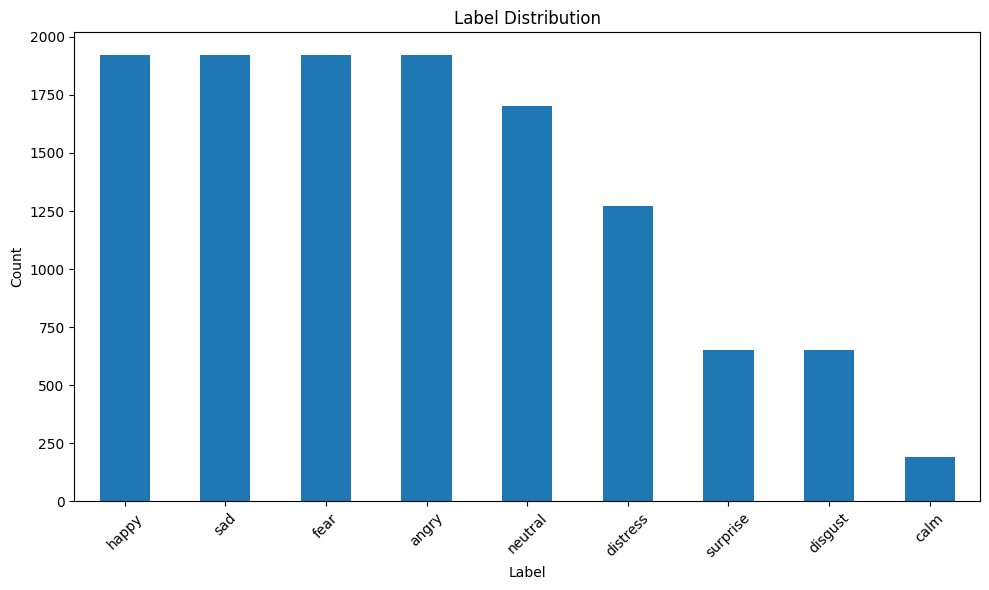

In [ ]:
label_counts = df['Label'].value_counts()

# Plot count plot for 'Label'
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We will do the following steps to process the audio

1. <strong>Load Audio</strong>: The audio file located at audio_path is loaded using the librosa.load function. The sr parameter specifies the desired sampling rate. The result is stored in y (the audio signal) and sr (the sampling rate).

2. <strong>Apply Pre-emphasis Filter</strong>: Pre-emphasis is applied to the audio signal y to emphasize high-frequency components. It involves subtracting a scaled version of the previous sample from the current sample. The scaled factor is given by pre_emphasis_alpha. The result is stored in y_preemphasized.

3. <strong>Split Audio into Frames</strong>: The pre-emphasized audio y_preemphasized is divided into frames of equal length using the librosa.util.frame function. frame_length specifies the length of each frame, and hop_length specifies the number of samples between the start of consecutive frames. The result is stored in frames.

4. <strong>Apply Windowing</strong>: A windowing function is applied to each frame to reduce spectral leakage and minimize artifacts at frame edges. In this case, the Hann window is used. The librosa.filters.get_window function provides the window values. The multiplication of each frame by the Hann window values results in frames_windowed.

<div style="color: yellow"> For visualization purpose we are returning all the stages of processing. The function actually to be used for processing the audio is written further below and returns ony the final result.</div>

In [ ]:
def preprocess_audio_visualize(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=sampling_rate)

    # Apply pre-emphasis filter
    y_preemphasized = np.append(y[0], y[1:] - pre_emphasis_alpha * y[:-1])

    # Split the audio into frames with overlapping
    frames = librosa.util.frame(y_preemphasized, frame_length=frame_length, hop_length=hop_length)

    # Apply windowing to each frame
    frames_windowed = frames * librosa.filters.get_window('hann', frame_length, fftbins=True)[:, np.newaxis]

    return y, y_preemphasized, frames_windowed, sr

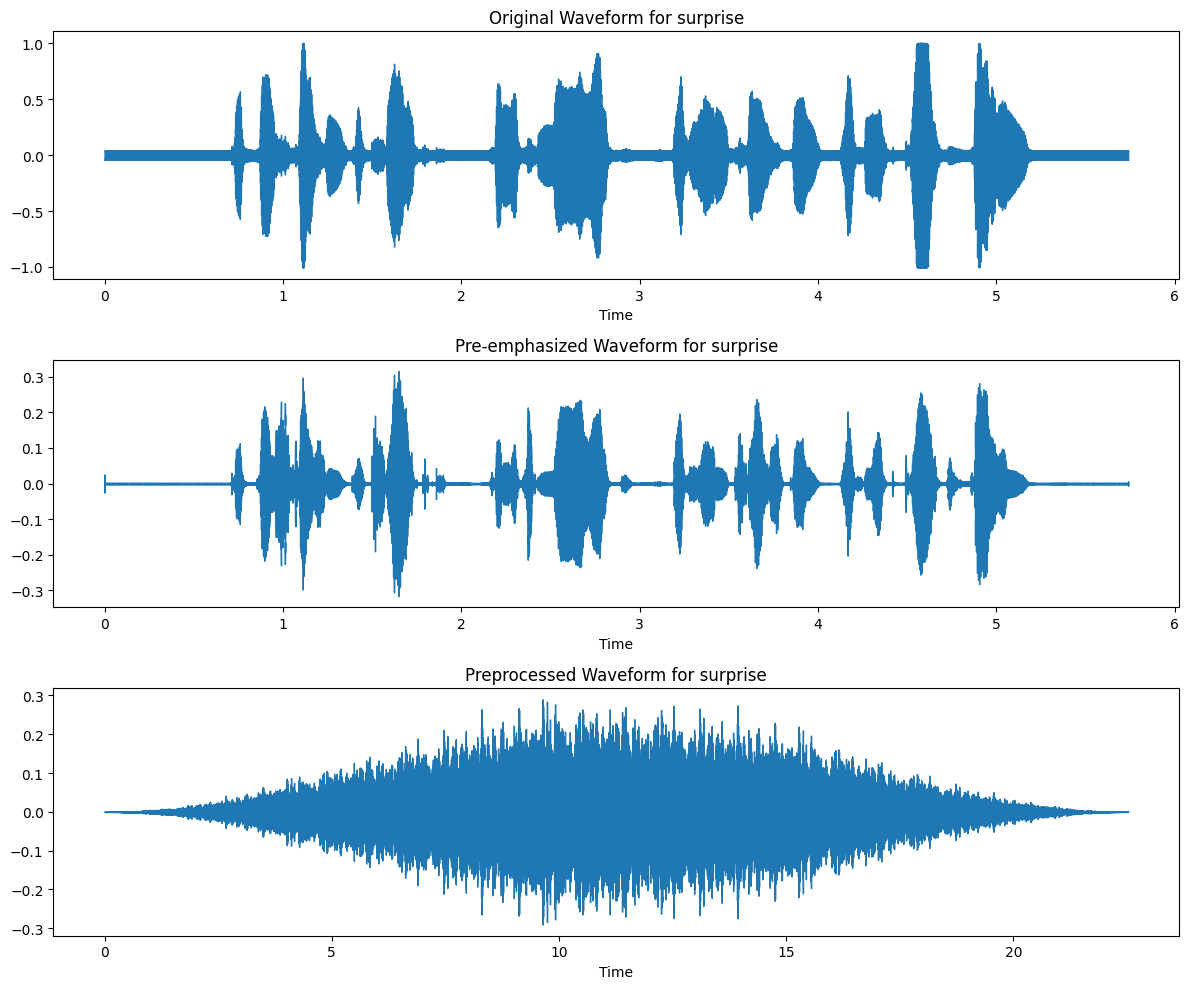

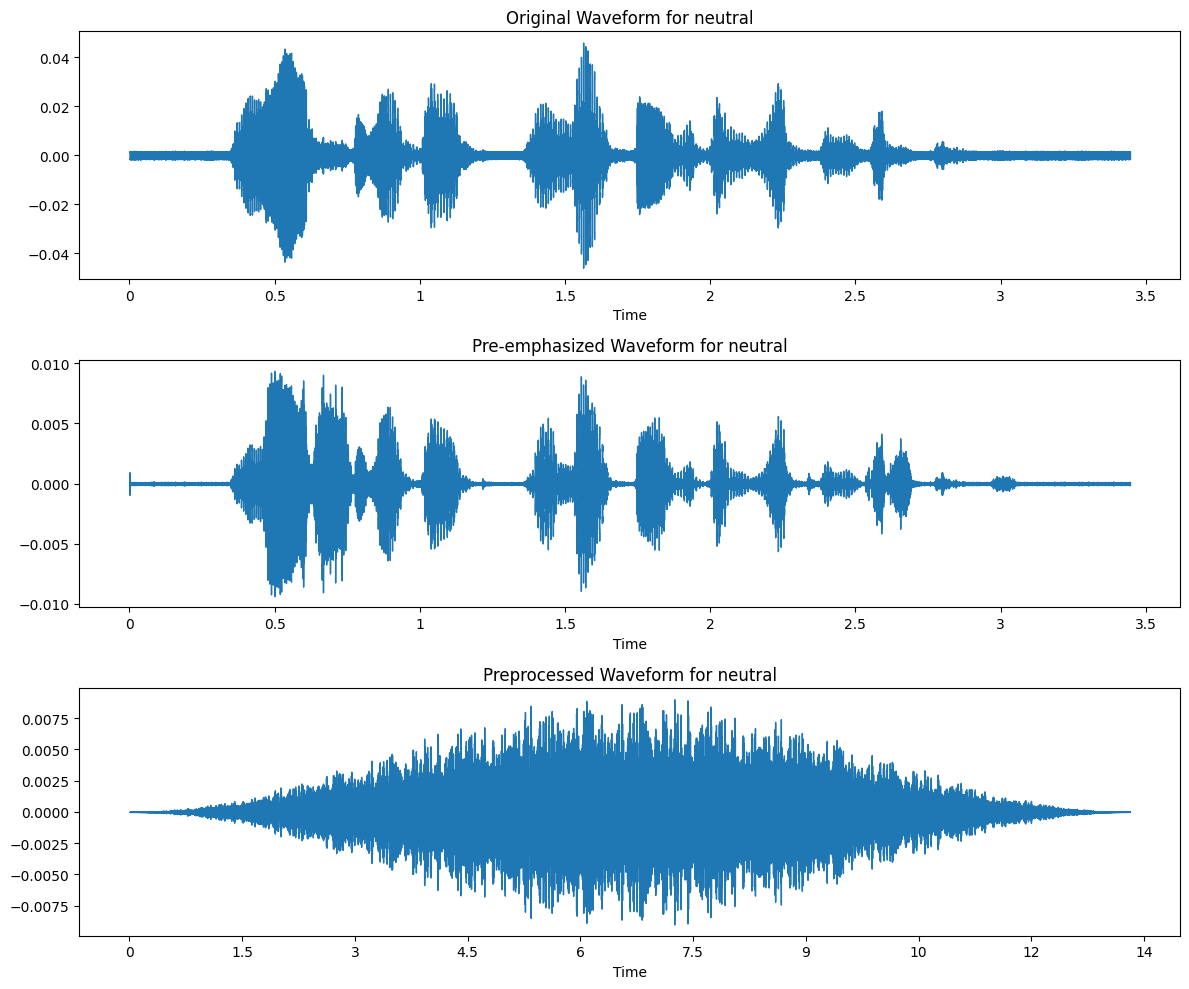

In [ ]:
audio_paths = df['Path'].tolist()
preprocessed_data = [preprocess_audio_visualize(audio_path) for audio_path in audio_paths[:2]]

for index, (y, y_preemphasized, frames_windowed, sr) in enumerate(preprocessed_data):
    label = df.loc[index, 'Label']

    # Plot all stages of preprocessing in subplots
    plt.figure(figsize=(12, 10))

    # Original waveform
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Original Waveform for {label}')

    # Pre-emphasized waveform
    plt.subplot(3, 1, 2)
    librosa.display.waveshow(y_preemphasized, sr=sr)
    plt.title(f'Pre-emphasized Waveform for {label}')

    # Preprocessed waveform with windowing
    plt.subplot(3, 1, 3)
    librosa.display.waveshow(frames_windowed.flatten(), sr=sr)
    plt.title(f'Preprocessed Waveform for {label}')

    plt.tight_layout()
    plt.show()


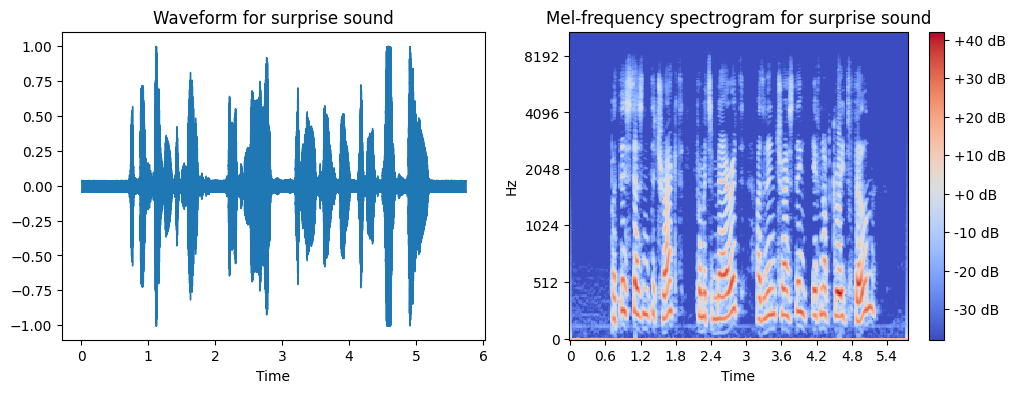

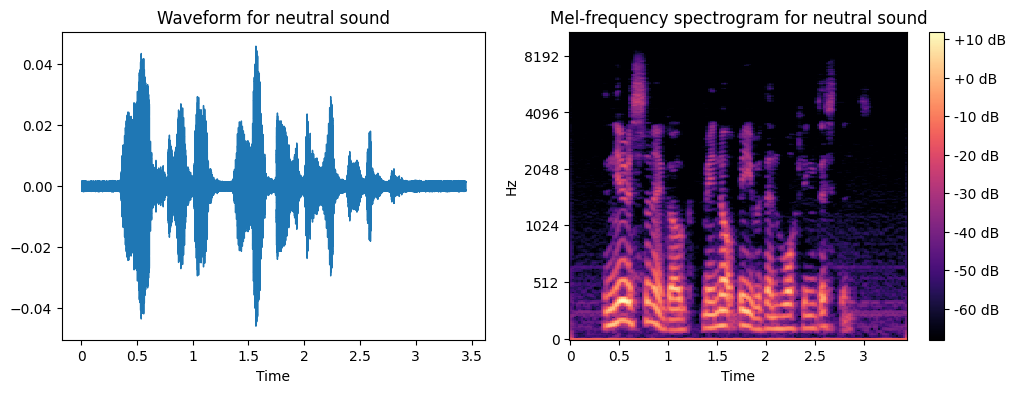

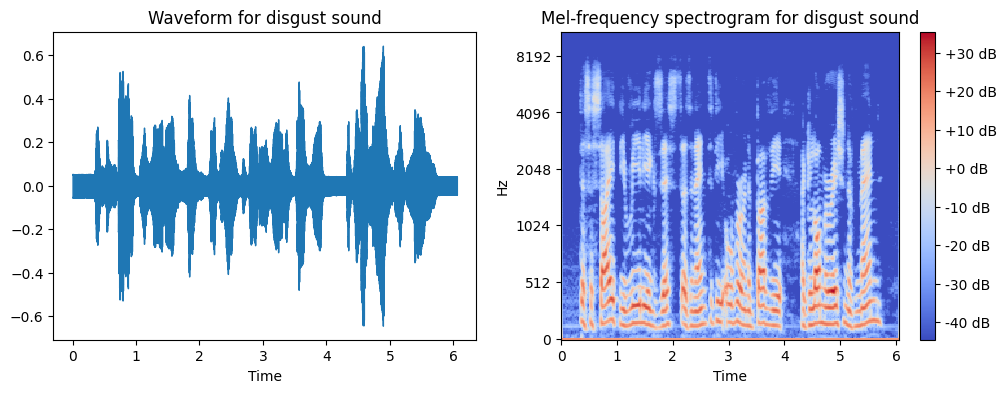

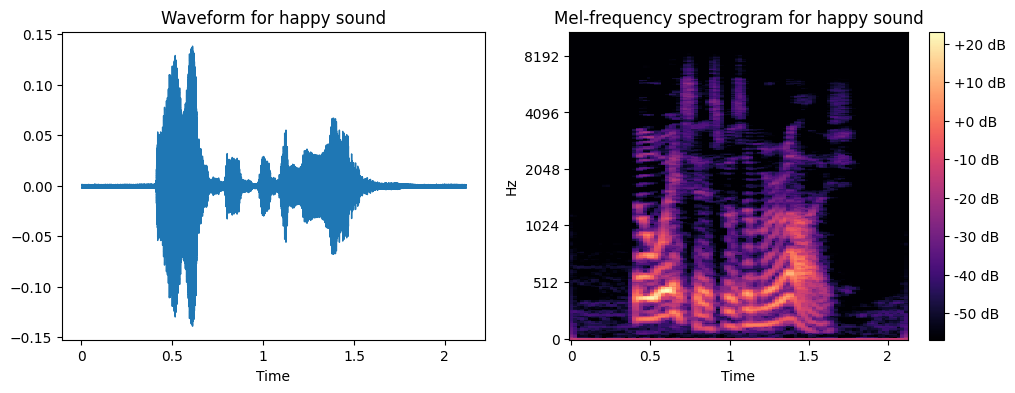

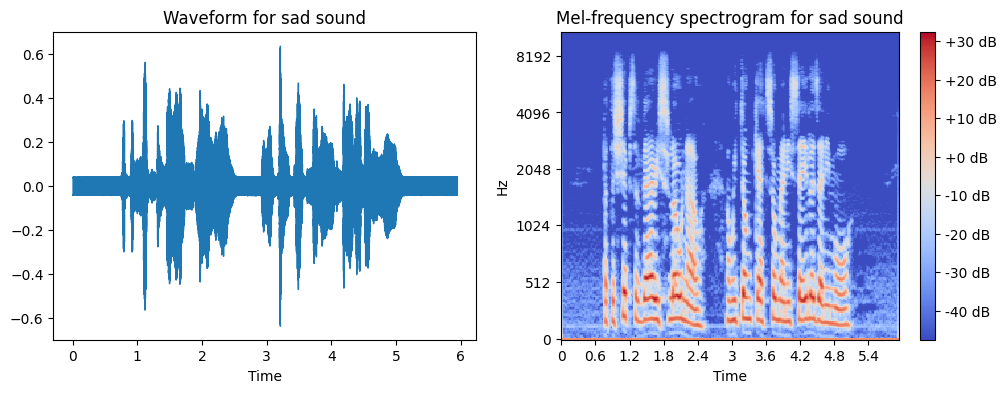

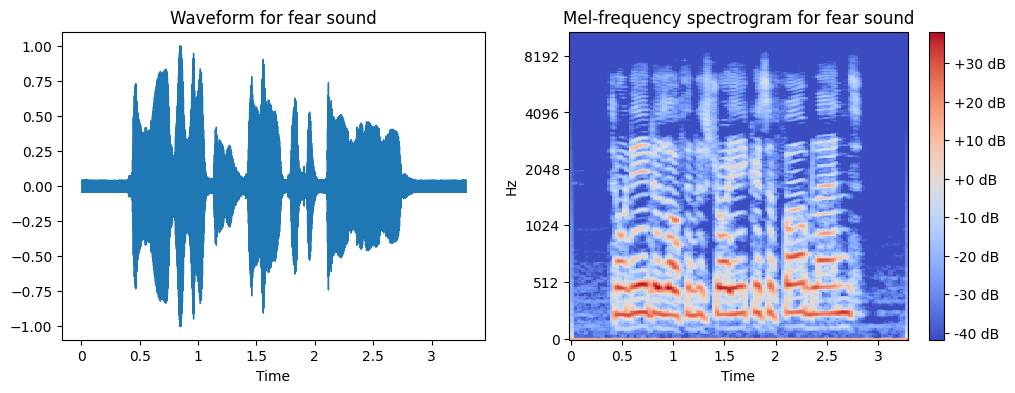

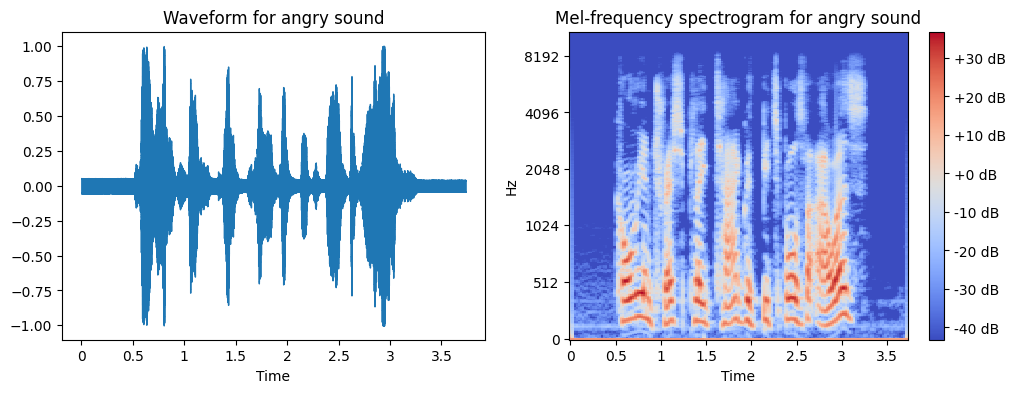

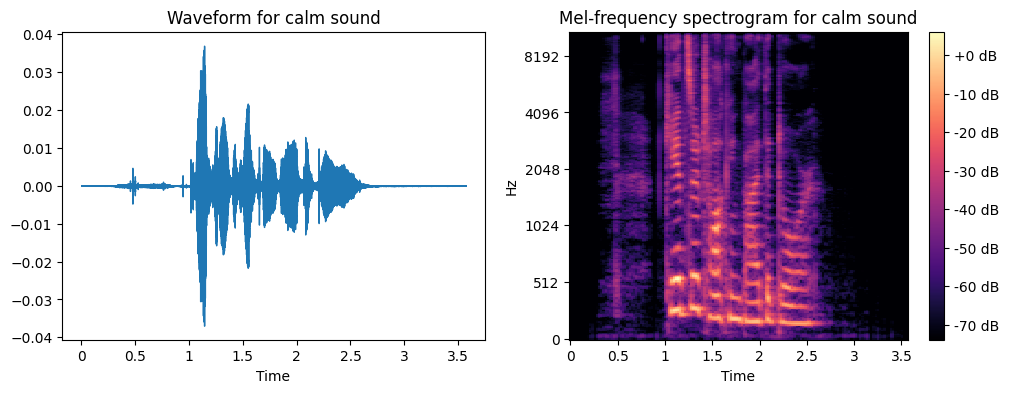

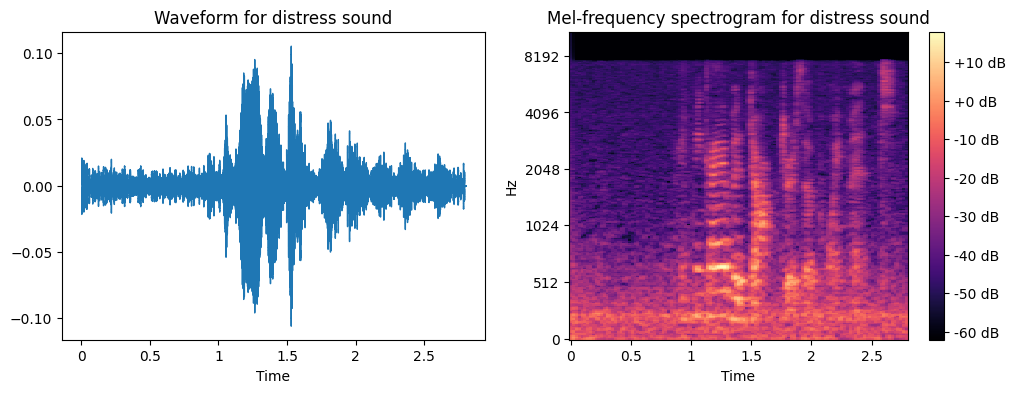

In [ ]:
def melspectogram_wave_plot(path, emotion):
    y, sr = librosa.load(path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=265, n_fft=2048, hop_length=512)
    S_dB = librosa.power_to_db(S)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot waveform on the left side (ax1)
    librosa.display.waveshow(y, sr=sr, ax=ax1)
    ax1.set(title=f'Waveform for {emotion} sound')

    # Plot mel-frequency spectrogram on the right side (ax2)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, ax=ax2)
    fig.colorbar(img, ax=ax2, format='%+2.0f dB')
    ax2.set(title=f'Mel-frequency spectrogram for {emotion} sound')

    plt.show()

emotion_names = df['Label'].unique().tolist()

for emotion in emotion_names:
    selected_row = df[df['Label'] == emotion].iloc[0]
    selected_audio_path = selected_row['Path']
    emotion = selected_row['Label']
    melspectogram_wave_plot(selected_audio_path, emotion)

# Pre-Processing and feature extraction

In [ ]:
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
import pickle
import h5py


# Parameters for preprocessing
sampling_rate = 8000
frame_length = 1024
hop_length = 512
pre_emphasis_alpha = 0.97
batch_size = 32


# Load the CSV file containing paths to audio files
csv_path = 'label.csv'
df = pd.read_csv(csv_path)

# Process audio in smaller batches
audio_paths = df['Path'].tolist()

First we are going to pre-process the data as we did visualize before. This code basically does these things:
- Performs pre-processing in batches and stores the immediate results to the disk. This way we can reduce our memory consumption. If we do it altogether, it will be a lot of burden on the memory.
- We also pad the output of the prepocessing module to make sure that all the outputs are of the same length. This is required for the models to work.

In [ ]:
def preprocess_audio(audio_path):
    y, sr = librosa.load(audio_path, sr=sampling_rate)
    y_preemphasized = np.append(y[0], y[1:] - pre_emphasis_alpha * y[:-1])
    del y
    frames = librosa.util.frame(y_preemphasized, frame_length=frame_length, hop_length=hop_length)
    del y_preemphasized
    frames_windowed = frames * librosa.filters.get_window('hann', frame_length, fftbins=True)[:, np.newaxis]
    del frames
    return frames_windowed


In [ ]:
max_frames = 0
for audio_path in audio_paths:
    frames = preprocess_audio(audio_path)
    max_frames = max(max_frames, frames.shape[1])

In [ ]:
# Create an HDF5 file to store the data
hdf5_path = 'preprocessed_data.h5'
hdf5_file = h5py.File(hdf5_path, 'w')

max_length = 0
batch_idx = 0

for i in tqdm(range(0, len(audio_paths), batch_size), desc='Preprocessing batches'):
    batch_audio_paths = audio_paths[i:i+batch_size]
    preprocessed_batch = []

    for audio_path in batch_audio_paths:
        batch_item = preprocess_audio(audio_path)

        # Pad the batch_item to match the maximum number of frames
        padded_item = np.pad(batch_item, ((0, 0), (0, max_frames - batch_item.shape[1])), mode='constant')
        preprocessed_batch.append(padded_item)

    # Create a dataset for the batch in the HDF5 file
    batch_dataset = hdf5_file.create_dataset(f'batch_{batch_idx}', data=np.array(preprocessed_batch))

    batch_dataset.attrs['batch_size'] = len(preprocessed_batch)

    batch_idx += 1


Preprocessing batches: 100%|██████████| 381/381 [02:17<00:00,  2.78it/s]


For now, we are extracting many features, we will experiment our model with variety of combination of features in future. These features include

- <strong>MFCC (Mel-Frequency Cepstral Coefficients):</strong> MFCCs capture audio spectral details, transforming frames into coefficients that represent frequency content, valuable for speech and audio analysis.

- <strong>Teager Energy Operator:</strong> Detects abrupt changes in audio by measuring energy differences between adjacent samples, highlighting transient events.

- <strong>Zero Crossing Rate (ZCR):</strong> Quantifies signal oscillations by counting zero crossings, useful for identifying percussive and rapid-changing sounds.

- <strong>Power Spectral Density (PSD):</strong> Shows energy distribution across frequencies via Short-Time Fourier Transform (STFT), aiding genre classification and audio synthesis.

- <strong>Mel Filter Bank Coefficients:</strong> Represents energy in frequency bands aligned with human hearing perception, providing a compact frequency characterization.

- <strong>Short Term Energy (STE):</strong> Measures energy within audio segments, helping differentiate between quiet and loud portions.

- <strong>Mel Spectrogram:</strong> Displays energy over time and Mel-scale frequencies, offering a visual insight into audio's spectral evolution.

In [ ]:
# Feature extraction parameters
n_mfcc = 13  # Number of MFCC coefficients
n_fft = 2048  # FFT window size for FFT and PSD
n_mels = 40  # Number of MEL filter banks

In [ ]:
def extract_mfcc(frames_windowed, sr):
    mfccs = librosa.feature.mfcc(y=frames_windowed, sr=sr, n_mfcc=n_mfcc)
    return mfccs

def extract_teager_energy(frames_windowed):
    teager_energy = np.sum(frames_windowed[1:-1] ** 2 - frames_windowed[0:-2] * frames_windowed[2:], axis=0)
    return teager_energy

def extract_zero_crossing_rate(frames_windowed):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=frames_windowed)
    return zero_crossing_rate

def extract_psd(frames_windowed, sr):
    psd = librosa.feature.melspectrogram(y=frames_windowed, sr=sr, n_fft=n_fft)
    return psd

def extract_mel_filter_bank(frames_windowed, sr):
    mel_filter_bank = librosa.feature.melspectrogram(y=frames_windowed, sr=sr, n_fft=n_fft, n_mels=n_mels)
    return mel_filter_bank

def extract_ste(frames_windowed):
    ste = np.sum(frames_windowed ** 2, axis=0)
    return ste

def extract_mel_spectrogram(frames_windows, sr):
    S = librosa.feature.melspectrogram(y=frames_windows, sr=sr, n_mels=128, n_fft=n_fft, hop_length=512)
    S_dB = librosa.power_to_db(S)
    return S_dB

In [ ]:
!rm 'extracted_features.h5'

# Load the pre-processed audio batches from the existing HDF5 file
hdf5_path = 'preprocessed_data.h5'
hdf5_file = h5py.File(hdf5_path, 'r')

# Create a new HDF5 file to store the extracted features
features_hdf5_path = 'extracted_features.h5'
features_hdf5_file = h5py.File(features_hdf5_path, 'w')

# Define the structured numpy dtype to hold feature data
feature_dtype = np.dtype([
    ('mfccs', np.float32, (1024, 13, 1)),       # MFCC coefficients
    ('teager_energy', np.float32, (110,)),      # Teager Energy
    ('zero_crossing_rate', np.float32, (1024, 1, 1)),  # Zero Crossing Rate
    ('psd', np.float32, (1024, 128, 1)),        # Power Spectral Density
    ('ste', np.float32, (110,)),                # Short Term Energy
    ('mel_spectrogram', np.float32, (1024, 128, 1))  # Mel Spectrogram
])

for batch_idx in tqdm(hdf5_file.keys(), desc='Extracting features'):
    batch_data = hdf5_file[batch_idx][:]
    batch_features = np.empty(len(batch_data), dtype=feature_dtype)

     # Iterate through audio frames in the batch
    for i, frame in enumerate(batch_data):
        mfccs = extract_mfcc(frame, sampling_rate)
        teager_energy = extract_teager_energy(frame)
        zero_crossing_rate = extract_zero_crossing_rate(frame)
        psd = extract_psd(frame, sampling_rate)
        ste = extract_ste(frame)
        mel_spectrogram = extract_mel_spectrogram(frame, sampling_rate)

        # Fill in the structured numpy array
        batch_features[i] = (
            mfccs, teager_energy, zero_crossing_rate,
            psd, ste, mel_spectrogram
        )

    # Create a dataset for the batch features in the new HDF5 file
    features_hdf5_file.create_dataset(batch_idx, data=batch_features)

# Close the HDF5 files
hdf5_file.close()
features_hdf5_file.close()

Extracting features: 100%|██████████| 381/381 [1:24:04<00:00, 13.24s/it]
